In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_1, get_X_2

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Electron Data

In [3]:
# importing data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


# Model Training

In [12]:
print(get_X_1.__doc__)


    Creates inputs for model training.
    Inputs include center etas, differences between center etas from different layers, and all energy information.
    All energy info means that all cells are passed as inputs in consistent ordering, without making any normalisations or changes.
    This type of model has all the information necessary to make predictions, but the inputs are not optimised in any way.
    


In [5]:
# split data into training and testing, next train XGBoost model
electrons.train_test_split(get_X=get_X_1, get_Y=get_Y_1, test_size=0.2)
print(electrons.X_test.shape)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}

electrons.train_xgboost_model(params)

(87000, 312)
INFO: Trained XGBoost model; mean squared error: 1399.408456904136


1399.408456904136

In [11]:
print(get_X_2.__doc__)


    Creates inputs for model training.
    Inputs include center etas, differences between center etas from different layers, and some energy information.
    Compared to get_X_2, this time a sum over phi axis is taken from calorimeter cell windows.
    The reasoning behind this is that the regression problem of finding z is independent of phi.
    This procedure greately decreases number of inputs, without any accuracy loss.
    


In [6]:
# split data into training and testing, next train XGBoost model
electrons.train_test_split(get_X=get_X_2, get_Y=get_Y_1, test_size=0.2)
print(electrons.X_test.shape)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    # "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}

electrons.train_xgboost_model(params)

(87000, 62)
INFO: Trained XGBoost model; mean squared error: 1352.504139806841


1352.504139806841

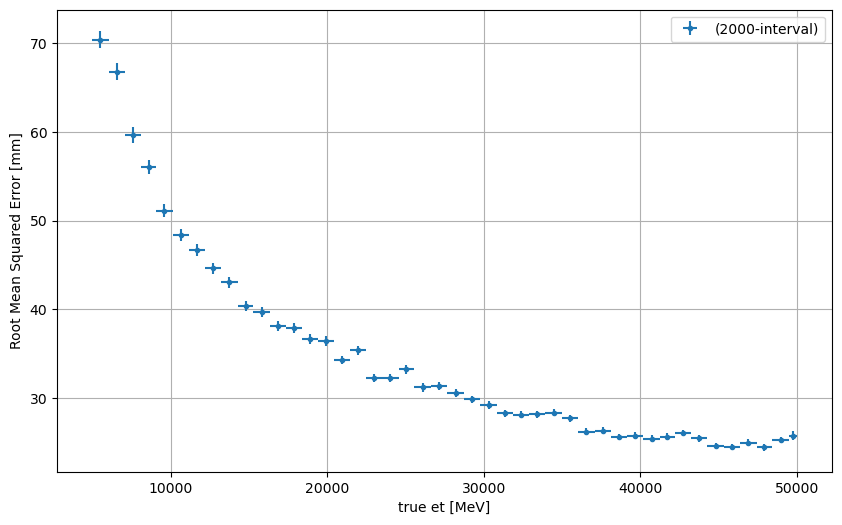

In [13]:
x_e, y_e, x_u_e, u_e = utils.plot_avg(
    x_values=electrons.testing_dataset["et"].values,
    y_values=(electrons.y_test - electrons.y_pred),
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="Root Mean Squared Error [mm]",
    return_x_u=True,
)